# Select and save oceanic regions from shapefile

In [1]:
import geopandas as gpd
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import sys
import os
import seaborn as sns
from scipy.stats import linregress
from scipy import stats
from dask import delayed
import imageio
#from joblib import Parallel, delayed
import matplotlib.dates as mdates
import intake
from DV8_functions_1 import *
import geopandas as gpd
import regionmask
import rasterio
#DV8_functions(1) packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FFMpegWriter
from matplotlib import animation, rc
from IPython.display import HTML
#my functions:


import matplotlib.colors as mcolors

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
import dask
from dask.distributed import Client, LocalCluster
import bokeh
import subprocess
import re

import warnings
#warnings.filterwarnings('ignore')


In [2]:


dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
cluster = LocalCluster(n_workers=32,threads_per_worker=1)
client = Client(cluster)
client

/home/b/b382616/.local/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39661 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/b382616/levante-spawner-advanced//proxy/39661/status,
Dashboard: /user/b382616/levante-spawner-advanced//proxy/39661/status,Workers: 32
Total threads: 32,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41985,Workers: 32
Dashboard: /user/b382616/levante-spawner-advanced//proxy/39661/status,Total threads: 32
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:40959,Total threads: 1
Dashboard: /user/b382616/levante-spawner-advanced//proxy/40907/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:42383,


In [44]:
filename='/scratch/b/b382615/mhws/ostia.zarr'  #Aaron's OSTIA already regriddewd to 0.25° resolution (ostia_1000 for detrend fixed, ostia for shifting)
#time_chunksize = 1000 #for detrend fixed, (lat and lon automatic)
#sst = xr.open_zarr(str(filename), chunks={"time": time_chunksize}).sst #fixed baseline chunks
sst = xr.open_zarr(str(filename), chunks={'time':30, 'lat':-1, 'lon':-1}).sst #shifting baseline chunks
#sst=sst.sel(time=slice('1982-01-01T12:00:00.000000000','2014-12-31T00:00:00.000000000'))
sst=sst-273.15
sst=sst.sel(time=slice('1997','2014-12-30T12:00:00.000000000'))

Flanders Marine Institute (2021). Global Oceans and Seas, version 1. Available online at https://www.marineregions.org/. https://doi.org/10.14284/542.

In [48]:
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds = xr.open_zarr(str(file_name), chunks={})
#ds = ds.sel(lat=slice(None, 70))
ossta=ds['dat_anomaly']


In [52]:
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'IFSFESOMhist_pre_1982_2014_shift_hob_maxanom5_oct25.zarr'
chunks={'time': 10, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
f_ds = xr.open_zarr(str(file_name), chunks=chunks)
f_ds = f_ds.sel(lat=slice(-50, 70))
f_ds = f_ds.interp(lat=ossta.lat, lon=ossta.lon)
fssta=f_ds['dat_anomaly']

/tmp/ipykernel_403386/129467252.py:3: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  f_ds = xr.open_zarr(str(file_name), chunks=chunks)


In [3]:
# IFS FESOM
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

dat = cat['dkrz.disk.model-output.ifs-fesom2-sr.hist-1950.v20240304.ocean.gr025']#.icon-esm-er.hist-1950.v20240618.ocean.gr025']


#time_chunksize = 1000
sst = dat['2D_daily_avg_1950-2014'].to_dask().avg_tos.isel(depth=0).drop_vars('depth').chunk({'time':30, 'lat':-1, 'lon':-1})
sst=sst.sel(time=slice('1982-01-01T12:00:00.000000000','2014-12-31T00:00:00.000000000'))       
#sst=sst-273.15

In [4]:
aug=sst.sel(time=('2000-08-01T12:00:00.000000000'),method='nearest')
dec=sst.sel(time=('2000-12-01T12:00:00.000000000'),method='nearest')

In [6]:
aug.sel(lat=-70,method='nearest').values

array([       nan, -1.8281462, -1.8294699, ...,        nan,        nan,
              nan], shape=(1440,), dtype=float32)

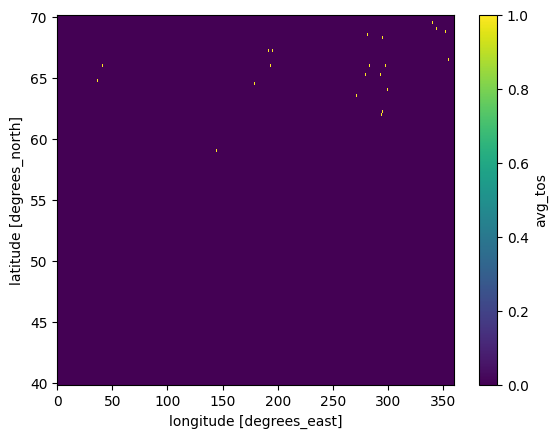

In [5]:
(sst.sel(lat=(slice(40,70)))==-1.7999878).any(dim='time').plot()

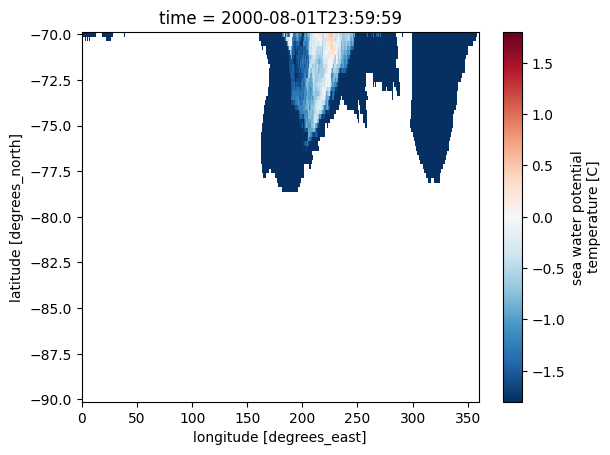

In [35]:
aug.sel(lat=(slice(-90,-70))).plot()

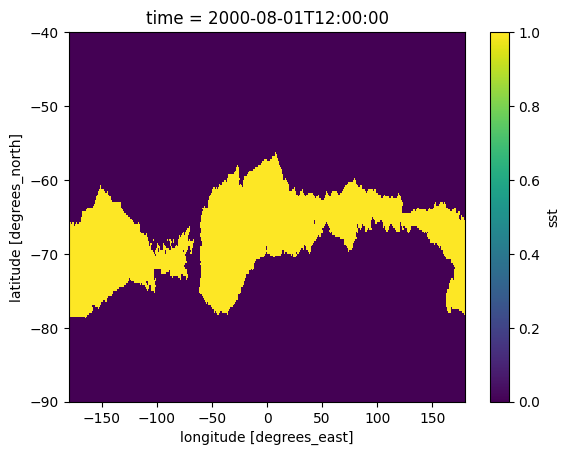

In [20]:
(aug.sel(lat=(slice(-90,-40)))==-1.7999878).plot()

In [27]:
import geopandas as gpd
import xarray as xr
from pathlib import Path
from getpass import getuser

# Path to save masks
save_path = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'DV8'
save_path.mkdir(parents=True, exist_ok=True)
mask_file = save_path / "region_masks.zarr"

# -----------------------------
# Check if masks already exist
if mask_file.exists():
    print("Loading existing masks...")
    region_masks_ds = xr.open_zarr(str(mask_file))
    region_masks = {var: region_masks_ds[var] for var in region_masks_ds.data_vars}
else:
    print("Creating masks...")
    region_masks = {}

    # Example SST slice
    example_sst = ossta.isel(time=0)
    example_sst = example_sst.rio.write_crs("EPSG:4326")

    # Load shapefile
    shapefile = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'DV8' / 'goas_v01.shp'
    oceans = gpd.read_file(shapefile).to_crs("EPSG:4326")

    # ----- Southern Ocean -----
    southern_oceans = oceans[oceans["name"].str.contains("South") | (oceans["name"]=="Indian Ocean")]
    mask_southern = example_sst.rio.clip(southern_oceans.geometry, southern_oceans.crs, drop=False)
    mask_southern_bool = ~xr.ufuncs.isnan(mask_southern)
    region_masks["Southern_Ocean"] = mask_southern_bool & (mask_southern_bool.lat <= -40)

    # ----- Mid/High latitude masks -----
    lat_bands = {
        "MidSouth": (-40, -10),
        "MidNorth": (10, 30),
        "Northern": (30, 70)
    }

    oceans_to_mask = ["North Pacific Ocean", "South Pacific Ocean",
                      "North Atlantic Ocean", "South Atlantic Ocean",
                      "Indian Ocean"]

    for ocean in oceans_to_mask:
        ocean_gdf = oceans[oceans["name"] == ocean]
        if ocean_gdf.empty:
            continue
        mask_da = example_sst.rio.clip(ocean_gdf.geometry, ocean_gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)

        for band_name, (lat_min, lat_max) in lat_bands.items():
            # Skip bands not relevant for this ocean
            if ocean == "Indian Ocean" and band_name == "Northern":
                continue
            if band_name == "Northern" and not (ocean.startswith("North") or ocean=="Indian Ocean"):
                continue
            if band_name == "MidSouth" and not (ocean.startswith("South") or ocean=="Indian Ocean"):
                continue
            if band_name == "MidNorth" and ocean.startswith("South"):
                continue  # remove South MidNorth masks

            region_masks[f"{ocean}_{band_name}"] = mask_bool & (mask_bool.lat >= lat_min) & (mask_bool.lat <= lat_max)

    # ----- Equatorial masks -----
    equatorial_oceans = ["Pacific", "Atlantic", "Indian"]
    equatorial_lat = (-10, 10)

    for eq_ocean_name in equatorial_oceans:
        gdf = oceans[oceans["name"].str.contains(eq_ocean_name)]
        if gdf.empty:
            continue
        mask_da = example_sst.rio.clip(gdf.geometry, gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)
        region_masks[f"{eq_ocean_name}_Equatorial"] = mask_bool & (mask_bool.lat >= equatorial_lat[0]) & (mask_bool.lat <= equatorial_lat[1])

    # ----- Small seas -----
    small_seas = {
        "Mediterranean_Sea": "Mediterranean Region",
        "Baltic_Sea": "Baltic Sea",
        "South_China_Eastern_Archipelagic_Seas": "South China and Easter Archipelagic Seas"
    }

    for key, name in small_seas.items():
        gdf = oceans[oceans["name"] == name]
        if gdf.empty:
            continue
        mask_da = example_sst.rio.clip(gdf.geometry, gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)
        region_masks[key] = mask_bool

    # ----- Save masks to Zarr -----
    region_masks_ds = xr.Dataset(region_masks)
    region_masks_ds.to_zarr(str(mask_file))
    print(f"Masks saved to {mask_file}")


Creating masks...


ERROR 1: PROJ: internal_proj_create_from_database: /sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
/home/b/b382616/.local/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 10.91 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Masks saved to /scratch/b/b382616/mhws/DV8/region_masks.zarr


In [120]:
print(oceans["name"].unique())


['Southern Ocean' 'South Atlantic Ocean' 'South Pacific Ocean'
 'North Pacific Ocean' 'South China and Easter Archipelagic Seas'
 'Indian Ocean' 'Mediterranean Region' 'Baltic Sea' 'North Atlantic Ocean'
 'Arctic Ocean']


In [23]:
list(region_masks)


['Southern_Ocean',
 'Pacific_Equatorial',
 'Atlantic_Equatorial',
 'Indian_Equatorial',
 'North Pacific Ocean_MidNorth',
 'North Pacific Ocean_Northern',
 'South Pacific Ocean_MidSouth',
 'North Atlantic Ocean_MidNorth',
 'North Atlantic Ocean_Northern',
 'South Atlantic Ocean_MidSouth',
 'Indian Ocean_MidSouth',
 'Indian Ocean_MidNorth',
 'Mediterranean_Sea',
 'Baltic_Sea',
 'South_China_Eastern_Archipelagic_Seas']

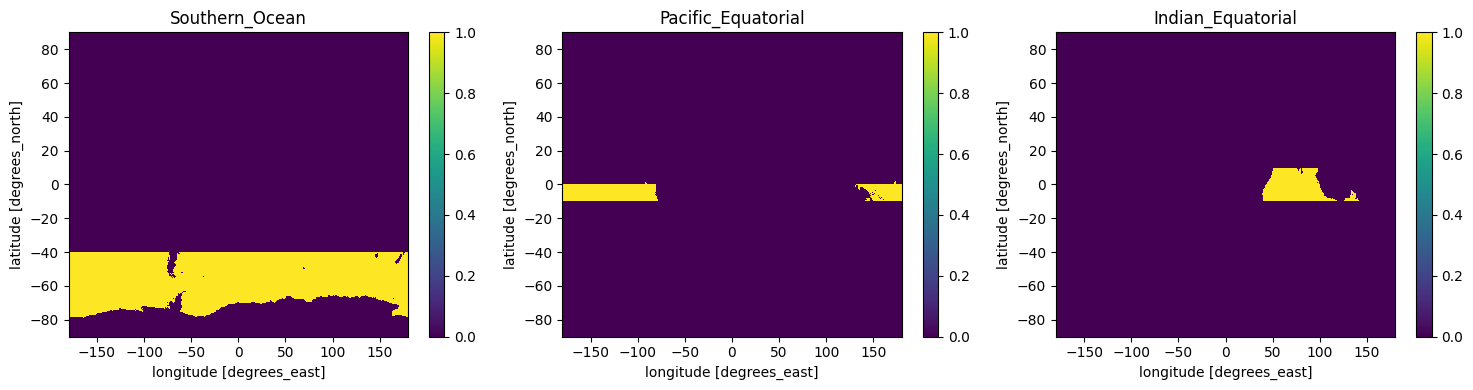

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors

# 1. Combine all masks into one array of integers
combined = xr.full_like(list(region_masks.values())[0], fill_value=0, dtype=int)

for i, (name, mask) in enumerate(region_masks.items(), start=1):
    combined = combined.where(~mask, other=i)

# 2. Set up colormap and legend
num_regions = len(region_masks)
cmap = plt.get_cmap("tab20", num_regions)
labels = list(region_masks.keys())
norm = mcolors.BoundaryNorm(boundaries=np.arange(0, num_regions+1), ncolors=num_regions)

# 3. Plot with Cartopy
fig, ax = plt.subplots(figsize=(14,6), subplot_kw={'projection': ccrs.PlateCarree()})
im = combined.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# Add coastlines and gridlines
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='black', zorder=2)
ax.gridlines()

# 4. Create legend manually
handles = [plt.Line2D([0], [0], marker='s', color=cmap(i), linestyle='', markersize=10)
           for i in range(num_regions)]
ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(1.05, 0.1), title="Regions")

plt.title("Ocean Masks")
plt.show()


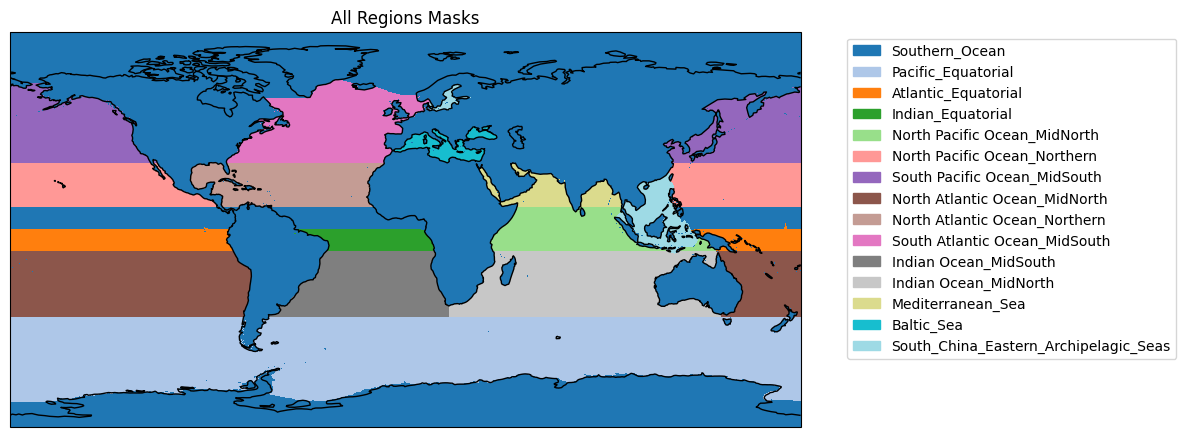

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr

# Create a combined mask array
combined = xr.zeros_like(list(region_masks.values())[0], dtype=int)

# Assign a unique integer to each mask
for i, (name, mask_da) in enumerate(region_masks.items(), start=1):
    combined = combined + mask_da.astype(int) * i

# Create a colormap with enough distinct colors
num_regions = len(region_masks)
cmap = plt.get_cmap("tab20", num_regions)

# Plot
fig, ax = plt.subplots(figsize=(12,6), subplot_kw={'projection': ccrs.PlateCarree()})
im = combined.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False)

# Add coastlines
ax.add_feature(cfeature.COASTLINE)
ax.set_global()
ax.set_title("All Regions Masks")

# Add a legend
from matplotlib.patches import Patch
handles = [Patch(color=cmap(i), label=name) for i, name in enumerate(region_masks.keys())]
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [18]:
list(region_masks)

['Southern_Ocean',
 'Pacific_Equatorial',
 'Atlantic_Equatorial',
 'Indian_Equatorial',
 'North Pacific Ocean_MidNorth',
 'North Pacific Ocean_Northern',
 'South Pacific Ocean_MidSouth',
 'South Pacific Ocean_MidNorth',
 'North Atlantic Ocean_MidNorth',
 'North Atlantic Ocean_Northern',
 'South Atlantic Ocean_MidSouth',
 'South Atlantic Ocean_MidNorth',
 'Indian Ocean_MidSouth',
 'Indian Ocean_MidNorth',
 'Mediterranean_Sea',
 'Baltic_Sea',
 'South_China_Eastern_Archipelagic_Seas']

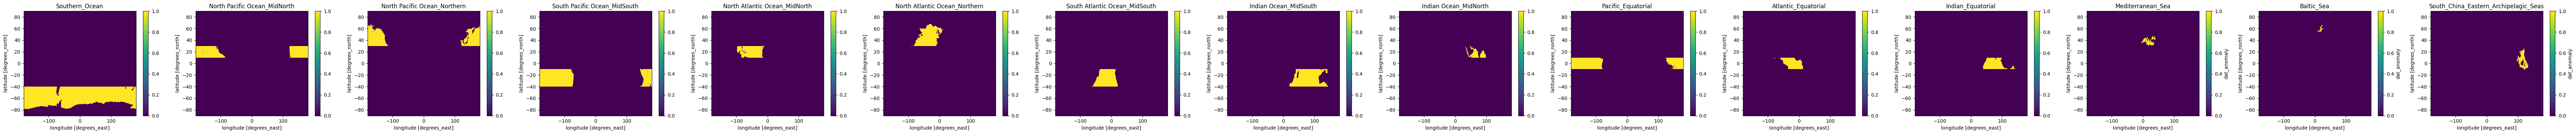

In [28]:
masks_to_check = list(region_masks)

fig, axes = plt.subplots(1, len(masks_to_check), figsize=(5*len(masks_to_check), 4))

for ax, name in zip(axes, masks_to_check):
    region_masks[name].plot(ax=ax)
    ax.set_title(name)

plt.tight_layout()
plt.show()


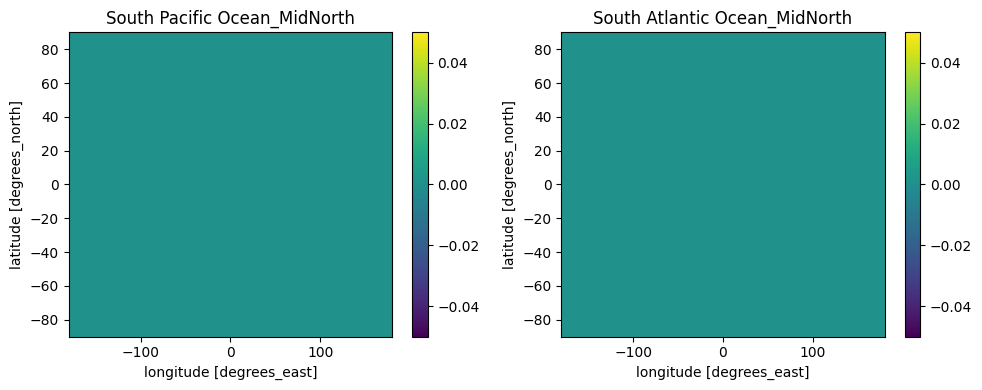

In [21]:
masks_to_check = ['South Pacific Ocean_MidNorth','South Atlantic Ocean_MidNorth']

fig, axes = plt.subplots(1, len(masks_to_check), figsize=(5*len(masks_to_check), 4))

for ax, name in zip(axes, masks_to_check):
    region_masks[name].plot(ax=ax)
    ax.set_title(name)

plt.tight_layout()
plt.show()


# MODIFICHE VARIE

In [11]:
# OSTIA ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds = xr.open_zarr(str(file_name), chunks=chunks)
ds = ds.sel(lat=slice(None, 70))
ossta=ds['dat_anomaly']

In [24]:
import geopandas as gpd
import xarray as xr
from pathlib import Path
from getpass import getuser

# Path to save masks
save_path = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'DV8'
save_path.mkdir(parents=True, exist_ok=True)
mask_file = save_path / "region_masks_xcvbnm.zarr"

# -----------------------------
# Check if masks already exist
if mask_file.exists():
    print("Loading existing masks...")
    region_masks_ds = xr.open_zarr(str(mask_file))
    region_masks = {var: region_masks_ds[var] for var in region_masks_ds.data_vars}
else:
    print("Creating masks...")
    region_masks = {}

    # Example SST slice
    example_sst = ossta.isel(time=0)
    example_sst = example_sst.rio.write_crs("EPSG:4326")

    # Load shapefile
    shapefile = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'DV8' / 'goas_v01.shp'
    oceans = gpd.read_file(shapefile).to_crs("EPSG:4326")

    # ----- Southern Ocean -----
    southern_oceans = oceans[oceans["name"].str.contains("South") | (oceans["name"]=="Indian Ocean")]
    mask_southern = example_sst.rio.clip(southern_oceans.geometry, southern_oceans.crs, drop=False)
    mask_southern_bool = ~xr.ufuncs.isnan(mask_southern)
    region_masks["Southern_Ocean"] = mask_southern_bool & (mask_southern_bool.lat <= -40)

    # ----- Mid/High latitude masks -----
    lat_bands = {
        "MidSouth": (-40, -10),
        "MidNorth": (10, 30),
        "Northern": (30, 70)
    }

    oceans_to_mask = ["North Pacific Ocean", "South Pacific Ocean",
                      "North Atlantic Ocean", "South Atlantic Ocean",
                      "Indian Ocean"]

    for ocean in oceans_to_mask:
        ocean_gdf = oceans[oceans["name"] == ocean]
        if ocean_gdf.empty:
            continue
        mask_da = example_sst.rio.clip(ocean_gdf.geometry, ocean_gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)

        for band_name, (lat_min, lat_max) in lat_bands.items():
            # Skip bands not relevant for this ocean
            if ocean == "Indian Ocean" and band_name == "Northern":
                continue
            if band_name == "Northern" and not (ocean.startswith("North") or ocean=="Indian Ocean"):
                continue
            if band_name == "MidSouth" and not (ocean.startswith("South") or ocean=="Indian Ocean"):
                continue
            if band_name == "MidNorth" and ocean.startswith("South"):
                continue  # remove South MidNorth masks

            region_masks[f"{ocean}_{band_name}"] = mask_bool & (mask_bool.lat >= lat_min) & (mask_bool.lat <= lat_max)

    # ----- Equatorial masks -----
    equatorial_oceans = ["Pacific", "Atlantic", "Indian"]
    equatorial_lat = (-10, 10)

    for eq_ocean_name in equatorial_oceans:
        gdf = oceans[oceans["name"].str.contains(eq_ocean_name)]
        if gdf.empty:
            continue
        mask_da = example_sst.rio.clip(gdf.geometry, gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)
        region_masks[f"{eq_ocean_name}_Equatorial"] = mask_bool & (mask_bool.lat >= equatorial_lat[0]) & (mask_bool.lat <= equatorial_lat[1])

    # ----- Small seas -----
    small_seas = {
        "Mediterranean_Sea": "Mediterranean Region",
        "South_China_Eastern_Archipelagic_Seas": "South China and Easter Archipelagic Seas"
    }

    for key, name in small_seas.items():
        gdf = oceans[oceans["name"] == name]
        if gdf.empty:
            continue
        mask_da = example_sst.rio.clip(gdf.geometry, gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)
        region_masks[key] = mask_bool

    # ----- Save masks to Zarr -----
    
    print(f"Masks saved to {mask_file}")


Creating masks...


ERROR 1: PROJ: internal_proj_create_from_database: /sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


Masks saved to /scratch/b/b382616/mhws/DV8/region_masks_xcvbnm.zarr


In [26]:
list(region_masks)

['Southern_Ocean',
 'North Pacific Ocean_MidNorth',
 'North Pacific Ocean_Northern',
 'South Pacific Ocean_MidSouth',
 'North Atlantic Ocean_MidNorth',
 'North Atlantic Ocean_Northern',
 'South Atlantic Ocean_MidSouth',
 'Indian Ocean_MidSouth',
 'Indian Ocean_MidNorth',
 'Pacific_Equatorial',
 'Atlantic_Equatorial',
 'Indian_Equatorial',
 'Mediterranean_Sea',
 'South_China_Eastern_Archipelagic_Seas']

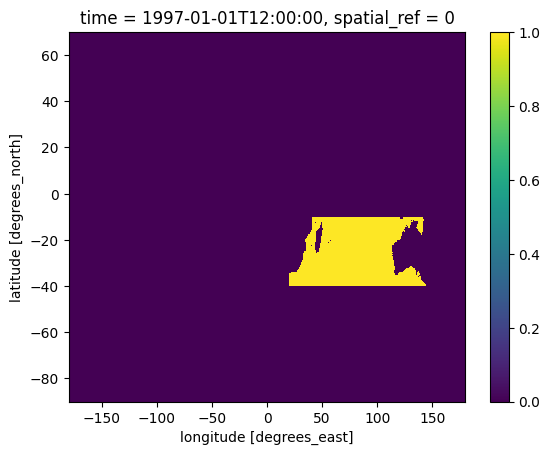

In [45]:
region_masks['Indian Ocean_MidSouth'].plot()

In [38]:
# Select masks
pacific = region_masks['Pacific_Equatorial']
south_china = region_masks['South_China_Eastern_Archipelagic_Seas']
indian = region_masks['Indian_Equatorial']

# 1️⃣ Restrict Pacific & South China masks to -10 <= lat <= 10
lat_mask = (pacific.lat >= -10) & (pacific.lat <= 10)

pacific_eq = pacific.where(lat_mask, False)
south_china_eq = south_china.where(lat_mask, False)

# 2️⃣ Restrict Indian mask to 120 <= lon <= 142
lon_mask = (indian.lon >= 120) & (indian.lon <= 142)
indian_eq = indian.where(lon_mask, False)

# 3️⃣ Combine all the masks into one
combined_mask = pacific_eq | south_china_eq | indian_eq


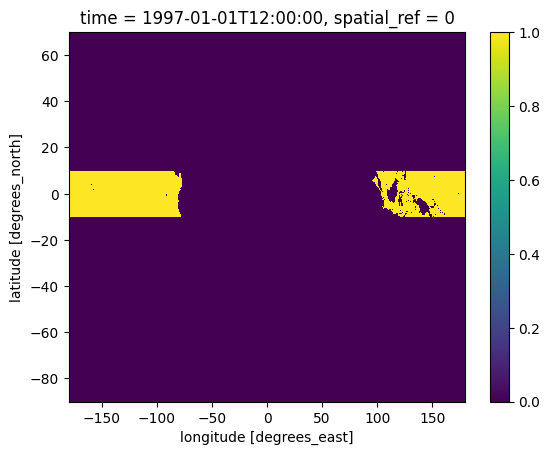

In [53]:
combined_mask.plot()

In [43]:
north_pacific = region_masks['North Pacific Ocean_MidNorth']
south_china = region_masks['South_China_Eastern_Archipelagic_Seas']

# Define latitude range mask
lat_mask = (north_pacific.lat >= 10) & (north_pacific.lat <= 30)

# Apply the lat restriction
north_pacific_band = north_pacific.where(lat_mask, False)
south_china_band = south_china.where(lat_mask, False)

# Combine (logical OR)
combined_mask_midnorth = north_pacific_band | south_china_band


In [49]:
indian_mid_south = region_masks['Indian Ocean_MidSouth']

# Define the lat/lon box
lat_mask = (indian_mid_south.lat >= -11) & (indian_mid_south.lat <= -10)
lon_mask = (indian_mid_south.lon >= 105) & (indian_mid_south.lon <= 130)

# Make a new boolean array for the box
box_mask = lat_mask & lon_mask

# Expand the original mask to include the box
indian_mid_south_expanded = indian_mid_south | box_mask


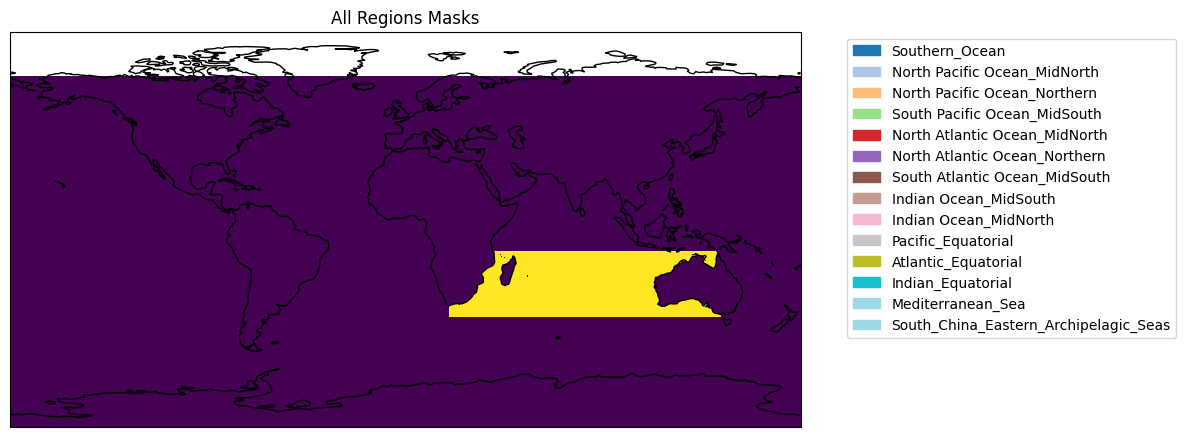

In [50]:



# Plot
fig, ax = plt.subplots(figsize=(12,6), subplot_kw={'projection': ccrs.PlateCarree()})
im = indian_mid_south_expanded.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False)

# Add coastlines
ax.add_feature(cfeature.COASTLINE)
ax.set_global()
ax.set_title("All Regions Masks")

# Add a legend
from matplotlib.patches import Patch
handles = [Patch(color=cmap(i), label=name) for i, name in enumerate(region_masks.keys())]
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


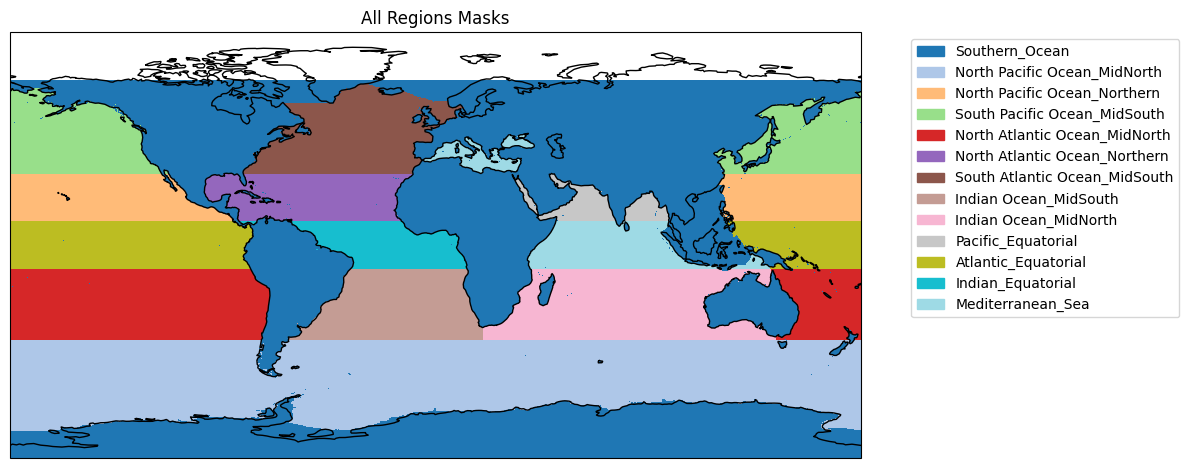

In [14]:


# Create a combined mask array
combined = xr.zeros_like(list(region_masks.values())[0], dtype=int)

# Assign a unique integer to each mask
for i, (name, mask_da) in enumerate(region_masks.items(), start=1):
    combined = combined + mask_da.astype(int) * i

# Create a colormap with enough distinct colors
num_regions = len(region_masks)
cmap = plt.get_cmap("tab20", num_regions)

# Plot
fig, ax = plt.subplots(figsize=(12,6), subplot_kw={'projection': ccrs.PlateCarree()})
im = combined.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False)

# Add coastlines
ax.add_feature(cfeature.COASTLINE)
ax.set_global()
ax.set_title("All Regions Masks")

# Add a legend
from matplotlib.patches import Patch
handles = [Patch(color=cmap(i), label=name) for i, name in enumerate(region_masks.keys())]
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [7]:
# OSTIA ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds = xr.open_zarr(str(file_name), chunks=chunks)
ds = ds.sel(lat=slice(None, 70))
ossta=ds['dat_anomaly']

# OSTIA BLOBS
#file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_track_1982_2014_maxanom5_mask70_oct25.zarr'
#oblobs = xr.open_zarr(str(file_name), chunks={})
# ICON HIST ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'ICONhist_pre_1982_2014_shift_hob_maxanom5_oct25.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
i_ds = xr.open_zarr(str(file_name), chunks=chunks)
#i_ds = i_ds.sel(lat=slice(None, 70))
issta=i_ds['dat_anomaly']



# IFS-FESOM ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'IFSFESOMhist_pre_1982_2014_shift_hob_maxanom5_oct25.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
f_ds = xr.open_zarr(str(file_name), chunks=chunks)
f_ds = f_ds.sel(lat=slice(None, 70))
fssta=f_ds['dat_anomaly']


In [24]:

# Create models dictionary
models_dict = {
   'OSTIA': (ds, 'dat_anomaly'),
    'ICON': (i_ds, 'dat_anomaly'),
    'IFS-FESOM': (f_ds, 'dat_anomaly'),  # Uncomment when you have this data
    # 'Other_Model': (other_ds, 'dat_anomaly'),    # Add more models here
}


In [58]:
def create_shapefile_oceanic_regions_mask(lats, lons, example_sst=None, shapefile_path=None, mask_file=None):
    """
    NEW VERSION - Create oceanic regions mask using shapefile-based approach
    MODIFIED: Incorporate the working region modifications as provided
    """
    # Create example_sst from lats and lons
    if lats.ndim == 1:
        lon_grid, lat_grid = np.meshgrid(lons, lats)
    else:
        lat_grid, lon_grid = lats, lons
    
    if example_sst == None:
        example_sst= xr.open_dataset('/home/b/b382616/scratch/mhws/DV8/example_sst.nc')
        example_sst=example_sst.dat_anomaly
    
    if shapefile_path is None:
        shapefile_path = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'DV8' / 'goas_v01.shp'
    
    if mask_file is None:
        save_path = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'DV8'
        save_path.mkdir(parents=True, exist_ok=True)
        mask_file = save_path / "region_masks_cvbnm.zarr"
    
    # Check if masks already exist
    if mask_file.exists():
        print("Loading existing masks...")
        region_masks_ds = xr.open_zarr(str(mask_file))
        region_masks = {var: region_masks_ds[var] for var in region_masks_ds.data_vars}
        return region_masks
    
    print("Creating masks from shapefile...")
    region_masks = {}

    # Prepare example SST
    example_sst = example_sst.rio.write_crs("EPSG:4326")

    # Load shapefile
    oceans = gpd.read_file(shapefile_path).to_crs("EPSG:4326")

    # ----- Southern Ocean -----
    southern_oceans = oceans[oceans["name"].str.contains("South") | (oceans["name"]=="Indian Ocean")]
    mask_southern = example_sst.rio.clip(southern_oceans.geometry, southern_oceans.crs, drop=False)
    mask_southern_bool = ~xr.ufuncs.isnan(mask_southern)
    region_masks["Southern_Ocean"] = mask_southern_bool & (mask_southern_bool.lat <= -40)

    # ----- Mid/High latitude masks -----
    lat_bands = {
        "MidSouth": (-40, -10), #South_SubTropics
        "MidNorth": (10, 30),
        "Northern": (30, 70)
    }

    oceans_to_mask = ["North Pacific Ocean", "South Pacific Ocean",
                      "North Atlantic Ocean", "South Atlantic Ocean",
                      "Indian Ocean"]

    for ocean in oceans_to_mask:
        ocean_gdf = oceans[oceans["name"] == ocean]
        if ocean_gdf.empty:
            continue
        mask_da = example_sst.rio.clip(ocean_gdf.geometry, ocean_gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)

        for band_name, (lat_min, lat_max) in lat_bands.items():
            # Skip bands not relevant for this ocean
            if ocean == "Indian Ocean" and band_name == "Northern":
                continue
            if band_name == "Northern" and not (ocean.startswith("North") or ocean=="Indian Ocean"):
                continue
            if band_name == "MidSouth" and not (ocean.startswith("South") or ocean=="Indian Ocean"):
                continue
            if band_name == "MidNorth" and ocean.startswith("South"):
                continue  # remove South MidNorth masks

            region_masks[f"{ocean}_{band_name}"] = mask_bool & (mask_bool.lat >= lat_min) & (mask_bool.lat <= lat_max)

    # ----- Equatorial masks -----
    equatorial_oceans = ["Pacific", "Atlantic", "Indian"]
    equatorial_lat = (-10, 10)

    for eq_ocean_name in equatorial_oceans:
        gdf = oceans[oceans["name"].str.contains(eq_ocean_name)]
        if gdf.empty:
            continue
        mask_da = example_sst.rio.clip(gdf.geometry, gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)
        region_masks[f"{eq_ocean_name}_Equatorial"] = mask_bool & (mask_bool.lat >= equatorial_lat[0]) & (mask_bool.lat <= equatorial_lat[1])

    # ----- Small seas -----
    small_seas = {
        "Mediterranean_Sea": "Mediterranean Region",
        "Baltic_Sea": "Baltic Sea",
        "South_China_Eastern_Archipelagic_Seas": "South China and Easter Archipelagic Seas"
    }

    for key, name in small_seas.items():
        gdf = oceans[oceans["name"] == name]
        if gdf.empty:
            continue
        mask_da = example_sst.rio.clip(gdf.geometry, gdf.crs, drop=False)
        mask_bool = ~xr.ufuncs.isnan(mask_da)
        region_masks[key] = mask_bool

    # ----- MODIFICATIONS: Apply the working region adjustments -----
    print("Applying region modifications...")
    
    # 1. Pacific Equatorial modification (combine Pacific, South China equatorial, and part of Indian)
    if ('Pacific_Equatorial' in region_masks and 
        'South_China_Eastern_Archipelagic_Seas' in region_masks and 
        'Indian_Equatorial' in region_masks):
        
        pacific = region_masks['Pacific_Equatorial']
        south_china = region_masks['South_China_Eastern_Archipelagic_Seas']
        indian = region_masks['Indian_Equatorial']

        # 1️⃣ Restrict Pacific & South China masks to -10 <= lat <= 10
        lat_mask = (pacific.lat >= -10) & (pacific.lat <= 10)
        pacific_eq = pacific.where(lat_mask, False)
        south_china_eq = south_china.where(lat_mask, False)

        # 2️⃣ Restrict Indian mask to 120 <= lon <= 142
        lon_mask = (indian.lon >= 120) & (indian.lon <= 142)
        indian_eq = indian.where(lon_mask, False)

        # 3️⃣ Combine all the masks into one
        combined_mask = pacific_eq | south_china_eq | indian_eq
        
        # 4️⃣ Remove the Indian equatorial points from 120-142°E and assign to Pacific
        region_masks['Pacific_Equatorial'] = combined_mask
        region_masks['Indian_Equatorial'] = indian.where(~lon_mask, False)

    # 2. North Pacific Subtropics modification (combine North Pacific and South China subtropical parts)
    if ('North Pacific Ocean_MidNorth' in region_masks and 
        'South_China_Eastern_Archipelagic_Seas' in region_masks):
        
        north_pacific = region_masks['North Pacific Ocean_MidNorth']
        south_china = region_masks['South_China_Eastern_Archipelagic_Seas']

        # Define latitude range mask
        lat_mask = (north_pacific.lat >= 10) & (north_pacific.lat <= 30)

        # Apply the lat restriction
        north_pacific_band = north_pacific.where(lat_mask, False)
        south_china_band = south_china.where(lat_mask, False)

        # Combine (logical OR)
        region_masks['North Pacific Ocean_MidNorth'] = north_pacific_band | south_china_band

    # 3. Indian South Subtropics modification (add specific box)
    if 'Indian Ocean_MidSouth' in region_masks:
        indian_mid_south = region_masks['Indian Ocean_MidSouth']

        # Define the lat/lon box
        lat_mask = (indian_mid_south.lat >= -11) & (indian_mid_south.lat <= -10)
        lon_mask = (indian_mid_south.lon >= 105) & (indian_mid_south.lon <= 130)

        # Make a new boolean array for the box
        box_mask = lat_mask & lon_mask

        # Expand the original mask to include the box
        region_masks['Indian Ocean_MidSouth'] = indian_mid_south | box_mask

    # 4. Remove Baltic Sea and South China Sea as separate regions
    regions_to_remove = ['Baltic_Sea', 'South_China_Eastern_Archipelagic_Seas']
    for region in regions_to_remove:
        if region in region_masks:
            del region_masks[region]
            print(f"Removed {region} from regions")

    # Mapping old mask names to new names
    rename_map = {
        "Indian Ocean_MidNorth": "Indian_NorthSubTropics",
        "Indian Ocean_MidSouth": "Indian_SouthSubTropics",
        "North Atlantic Ocean_MidNorth": "North_Atlantic_SubTropics",
        "North Atlantic Ocean_Northern": "North_Atlantic_MiddleLats",
        "North Pacific Ocean_MidNorth": "North_Pacific_SubTropics",
        "North Pacific Ocean_Northern": "North_Pacific_MiddleLats",
        "South Atlantic Ocean_MidSouth": "South_Atlantic_SubTropics",
        "South Pacific Ocean_MidSouth": "South_Pacific_SubTropics"
        # All others remain the same
    }
    
    # Apply renaming
    region_masks = {rename_map.get(k, k): v for k, v in region_masks.items()}

    # ----- NEW: Ensure masks are mutually exclusive -----
    region_masks = ensure_mutually_exclusive_masks(region_masks)

    # ----- Save masks to Zarr -----
    region_masks_ds = xr.Dataset(region_masks)
    #region_masks_ds.to_zarr(str(mask_file))
    print(f"Masks saved to {mask_file}")

    return region_masks




def ensure_mutually_exclusive_masks(region_masks, priority_order=None):
    """
    Ensure that no latitude/longitude point belongs to more than one mask.
    Uses a priority system to resolve conflicts.
    
    Parameters:
    - region_masks: dictionary of region masks
    - priority_order: list of region names in priority order (first has highest priority)
    
    Returns:
    - unique_masks: dictionary of mutually exclusive region masks
    """
    print("Ensuring masks are mutually exclusive...")
    
    if priority_order is None:
        # Define default priority order (you can modify this)
        priority_order = [
            'Southern_Ocean',           # Highest priority
            'Pacific_Equatorial',       # Next priority
            'Atlantic_Equatorial',
            'Indian_Equatorial',
            'North_Pacific_SubTropics',
            'North_Pacific_MiddleLats',
            'South_Pacific_SubTropics',
            'North_Atlantic_SubTropics',
            'North_Atlantic_MiddleLats',
            'South_Atlantic_SubTropics',
            'Indian_NorthSubTropics',
            'Indian_SouthSubTropics',
            'Mediterranean_Sea'         # Lowest priority
        ]
    
    # Convert all masks to numpy arrays for easier manipulation
    bool_masks = {}
    for region_name, mask in region_masks.items():
        bool_masks[region_name] = mask.values if hasattr(mask, 'values') else mask
    
    # Create a copy to modify
    unique_masks = bool_masks.copy()
    
    # Track conflicts
    total_conflicts = 0
    
    # Process regions in priority order
    for i, high_priority_region in enumerate(priority_order):
        if high_priority_region not in unique_masks:
            continue
            
        for j, low_priority_region in enumerate(priority_order[i+1:], i+1):
            if low_priority_region not in unique_masks:
                continue
                
            # Find overlapping points
            overlap = unique_masks[high_priority_region] & unique_masks[low_priority_region]
            conflict_count = np.sum(overlap)
            
            if conflict_count > 0:
                total_conflicts += conflict_count
                print(f"  Resolving {conflict_count} conflicts: {high_priority_region} over {low_priority_region}")
                
                # Remove overlapping points from lower priority region
                unique_masks[low_priority_region] = unique_masks[low_priority_region] & ~overlap
    
    print(f"Total conflicts resolved: {total_conflicts}")
    
    # Convert back to xarray DataArrays
    result_masks = {}
    for region_name, bool_mask in unique_masks.items():
        result_masks[region_name] = xr.DataArray(
            bool_mask,
            dims=('lat', 'lon'),
            coords={
                'lat': region_masks[region_name].lat if hasattr(region_masks[region_name], 'lat') else region_masks[region_name].coords['lat'],
                'lon': region_masks[region_name].lon if hasattr(region_masks[region_name], 'lon') else region_masks[region_name].coords['lon']
            },
            name=region_name
        )
    
    # Verify no overlaps remain
    verify_no_overlaps(result_masks)
    
    return result_masks

def verify_no_overlaps(region_masks):
    """
    Verify that no overlaps exist between masks
    """
    print("Verifying no overlaps between masks...")
    
    regions = list(region_masks.keys())
    total_overlaps = 0
    
    for i in range(len(regions)):
        region1 = regions[i]
        mask1 = region_masks[region1].values if hasattr(region_masks[region1], 'values') else region_masks[region1]
        
        for j in range(i+1, len(regions)):
            region2 = regions[j]
            mask2 = region_masks[region2].values if hasattr(region_masks[region2], 'values') else region_masks[region2]
            
            overlap = mask1 & mask2
            overlap_count = np.sum(overlap)
            
            if overlap_count > 0:
                total_overlaps += overlap_count
                print(f"  ❌ OVERLAP FOUND: {region1} and {region2} share {overlap_count} points")
    
    if total_overlaps == 0:
        print("  ✅ SUCCESS: No overlaps found between any masks")
    else:
        print(f"  ⚠️  WARNING: {total_overlaps} overlapping points remain")
    
    return total_overlaps == 0






def get_region_colors_shapefile():
    """
    Get color mapping for shapefile-based regions with updated names
    MODIFIED: Remove Baltic Sea and South China Sea colors
    """
    return {
        # Southern Ocean
        'Southern_Ocean': 'purple',
        
        # Pacific Ocean regions
        'North_Pacific_SubTropics': 'lightblue',
        'North_Pacific_MiddleLats': 'blue',
        'South_Pacific_SubTropics': 'darkblue',
        'Pacific_Equatorial': 'lightgreen',
        
        # Atlantic Ocean regions
        'North_Atlantic_SubTropics': 'yellow',
        'North_Atlantic_MiddleLats': 'orange',
        'South_Atlantic_SubTropics': 'red',
        'Atlantic_Equatorial': 'green',
        
        # Indian Ocean regions
        'Indian_SouthSubTropics': 'pink',
        'Indian_NorthSubTropics': 'magenta',
        'Indian_Equatorial': 'darkgreen',
        
        # Small seas (only Mediterranean remains)
        'Mediterranean_Sea': 'cyan'
        # REMOVED: 'Baltic_Sea': 'teal',
        # REMOVED: 'South_China_Eastern_Archipelagic_Seas': 'brown'
    }


def plot_region_masks(lats, lons, masks, title="Oceanic Regions Mask"):
    """
    Plot region masks using the renamed shapefile-based regions.
    UPDATED: Remove colors for deleted regions (Baltic Sea, South China Sea)
    """
    # Create coordinate grids if not already 2D
    if lats.ndim == 1:
        lon_grid, lat_grid = np.meshgrid(lons, lats)
    else:
        lat_grid, lon_grid = lats, lons

    # Use the updated color mapping (without Baltic Sea and South China Sea)
    colors = {
        # Southern Ocean
        'Southern_Ocean': 'purple',
        
        # Pacific Ocean regions
        'North_Pacific_SubTropics': 'lightblue',
        'North_Pacific_MiddleLats': 'blue',
        'South_Pacific_SubTropics': 'darkblue',
        'Pacific_Equatorial': 'lightgreen',
        
        # Atlantic Ocean regions
        'North_Atlantic_SubTropics': 'yellow',
        'North_Atlantic_MiddleLats': 'orange',
        'South_Atlantic_SubTropics': 'red',
        'Atlantic_Equatorial': 'green',
        
        # Indian Ocean regions
        'Indian_SouthSubTropics': 'pink',
        'Indian_NorthSubTropics': 'magenta',
        'Indian_Equatorial': 'darkgreen',
        
        # Small seas (only Mediterranean remains)
        'Mediterranean_Sea': 'cyan'
        # REMOVED: 'Baltic_Sea': 'teal',
        # REMOVED: 'South_China_Eastern_Archipelagic_Seas': 'brown'
    }
    print("Using updated shapefile-based region colors (Baltic Sea removed, South China Sea split)")

    fig = plt.figure(figsize=(15, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)

    for region, mask in masks.items():
        if region in colors:
            mask_data = mask.values if hasattr(mask, 'values') else mask
            # Only plot where mask is True
            masked_lat = lat_grid[mask_data]
            masked_lon = lon_grid[mask_data]
            ax.scatter(masked_lon, masked_lat, color=colors[region], s=1, transform=ccrs.PlateCarree())


    ax.coastlines(zorder=8)
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=10)
    ax.set_global()

    # Legend
    legend_patches = [
        mpatches.Patch(color=color, label=r.replace('_',' ').title())
        for r, color in colors.items()
    ]
    ax.legend(
        handles=legend_patches,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=4
    )
    
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    return fig, ax

Creating masks from shapefile...


ERROR 1: PROJ: internal_proj_create_from_database: /sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


Applying region modifications...
Removed Baltic_Sea from regions
Removed South_China_Eastern_Archipelagic_Seas from regions
Ensuring masks are mutually exclusive...
Total conflicts resolved: 0
Verifying no overlaps between masks...
  ✅ SUCCESS: No overlaps found between any masks
Masks saved to /scratch/b/b382616/mhws/DV8/region_masks_cvbnm.zarr
Using updated shapefile-based region colors (Baltic Sea removed, South China Sea split)


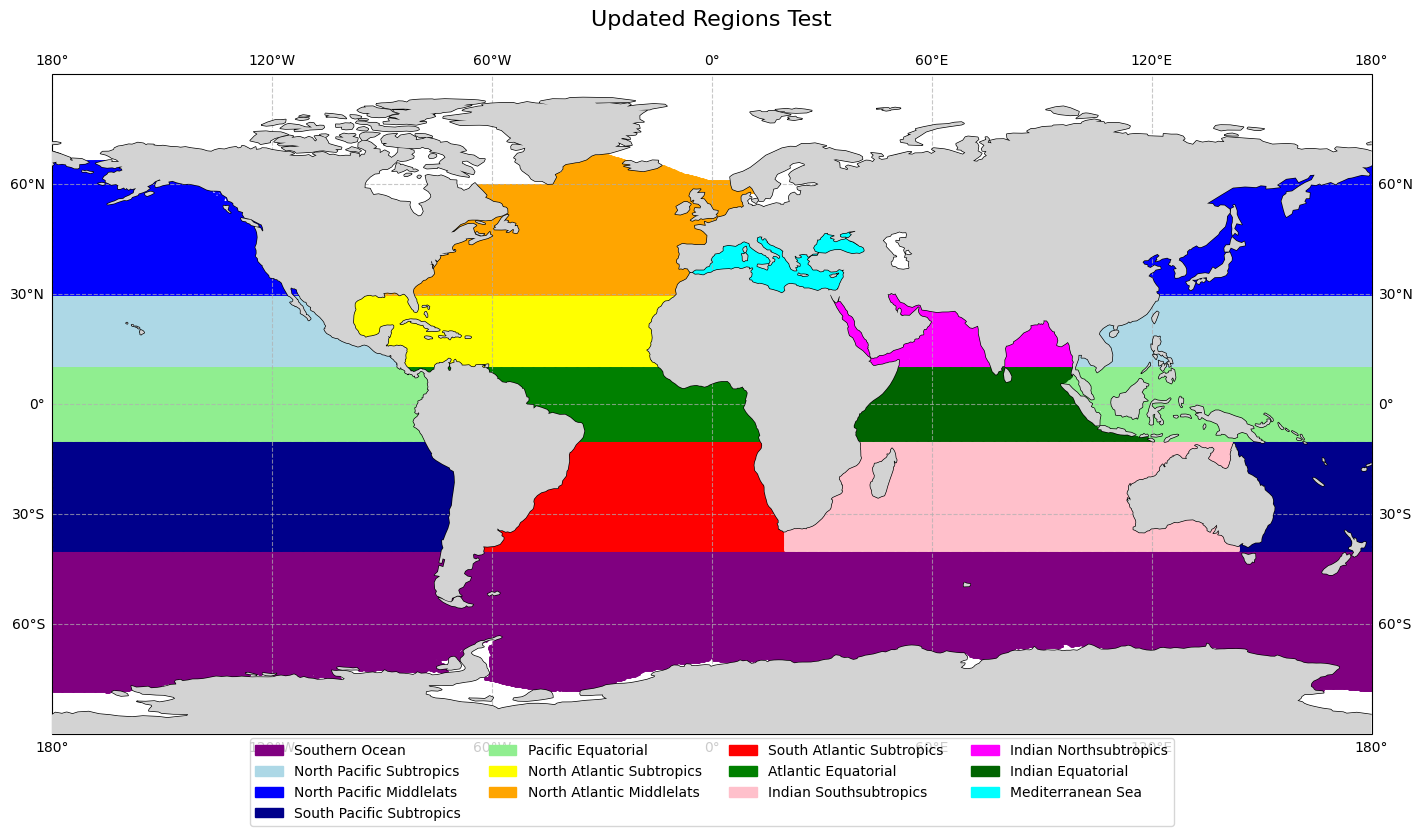

Region summary:
  Southern_Ocean: 179487 grid points
  North_Pacific_SubTropics: 46450 grid points
  North_Pacific_MiddleLats: 49110 grid points
  South_Pacific_SubTropics: 66316 grid points
  North_Atlantic_SubTropics: 23630 grid points
  North_Atlantic_MiddleLats: 34313 grid points
  South_Atlantic_SubTropics: 29888 grid points
  Indian_SouthSubTropics: 44121 grid points
  Indian_NorthSubTropics: 8252 grid points
  Pacific_Equatorial: 53415 grid points
  Atlantic_Equatorial: 16773 grid points
  Indian_Equatorial: 18283 grid points
  Mediterranean_Sea: 4899 grid points


In [59]:
# Quick test
# LATS and LONS for mask
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds_exmp = xr.open_zarr(str(file_name), chunks=chunks)


lats=ds_exmp.lat
lons=ds_exmp.lon

masks = create_shapefile_oceanic_regions_mask(lats, lons)
fig, ax = plot_region_masks(lats, lons, masks, title="Updated Regions Test")
plt.show()

# Print region summary
print("Region summary:")
for region, mask in masks.items():
    count = np.sum(mask.values) if hasattr(mask, 'values') else np.sum(mask)
    print(f"  {region}: {count} grid points")